In [1]:
import os
import urllib.request
from types import SimpleNamespace
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

%matplotlib inline
from IPython.display import HTML, display, set_matplotlib_formats
from PIL import Image
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from random import choices
from torchvision import transforms
from torchvision.datasets import CIFAR10

from utils import weighted_mean, weighted_sd, read_results
from torch_utils import d_LSE, BI_LSE, BI_thresh_acc_DE, BI_thresh_acc_TTA, Conf_thresh_acc, BI_thresh_acc_MCD, BI_thresh_DE, Conf_thresh

import torch.nn.functional as F
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

ds_name = 'Cifar10-C'

/tmp/ipykernel_3846554/2995713119.py:34: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export


In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "../data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "../saved_models/ConvNets")


# Function for setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Global seed set to 42


In [3]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# Files to download
pretrained_files = [
    "GoogleNet.ckpt",
    "ResNet.ckpt",
    "ResNetPreAct.ckpt",
    "DenseNet.ckpt",
    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
    "tensorboards/ResNet/events.out.tfevents.resnet",
    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
    "tensorboards/DenseNet/events.out.tfevents.densenet",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

In [4]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0, 1, 2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [5]:
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(DATA_MEANS, DATA_STD)])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD),
    ]
)
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Global seed set to 42
Global seed set to 42


Files already downloaded and verified


In [6]:
class CIFARModule(pl.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

In [7]:
model_dict = {}


def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f'Unknown model name "{model_name}". Available models are: {str(model_dict.keys())}'

In [8]:
act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU}

In [9]:
def train_model(model_name, save_name=None, seed=42, max_epochs=180, verbose=True, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name + '_seed{}'.format(seed)

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        accelerator='gpu',
        devices=1,
        # How many epochs to train for if no patience is set
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch")
        ],  # Log learning rate every epoch
        enable_progress_bar=verbose,
        logger=verbose,
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    if verbose:
        trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
        trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = CIFARModule.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(seed)
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training
        trainer.save_checkpoint(pretrained_filename)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [10]:
def train_BS_model(model_name, save_name=None, seed=42, max_epochs=180, verbose=True, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name + '_BS_seed{}'.format(seed)

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        accelerator='gpu',
        devices=1,
        # How many epochs to train for if no patience is set
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            #LearningRateMonitor("epoch")
        ],  # Log learning rate every epoch
        enable_progress_bar=verbose,
        logger=verbose,
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    if verbose:
        trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
        trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = CIFARModule.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(seed)
        BS_indices = choices(range(len(train_set)), k=len(train_set))
        BS_set = data.Subset(train_set, BS_indices)
        train_loader = data.DataLoader(
            BS_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training
        trainer.save_checkpoint(pretrained_filename)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [11]:
class ResNetBlock(nn.Module):
    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.Conv2d(
                c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False
            ),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
        )

        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

In [12]:
class PreActResNetBlock(nn.Module):
    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
        )

        # 1x1 convolution needs to apply non-linearity as well as not done on skip connection
        self.downsample = (
            nn.Sequential(nn.BatchNorm2d(c_in), act_fn(), nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False))
            if subsample
            else None
        )

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

In [13]:
resnet_blocks_by_name = {"ResNetBlock": ResNetBlock, "PreActResNetBlock": PreActResNetBlock}

In [14]:
class ResNet(nn.Module):
    def __init__(
        self,
        num_classes=10,
        num_blocks=[3, 3, 3],
        c_hidden=[16, 32, 64],
        act_fn_name="relu",
        block_name="ResNetBlock",
        **kwargs,
    ):
        """
        Inputs:
            num_classes - Number of classification outputs (10 for CIFAR10)
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks. Usually multiplied by 2 the deeper we go.
            act_fn_name - Name of the activation function to use, looked up in "act_fn_by_name"
            block_name - Name of the ResNet block, looked up in "resnet_blocks_by_name"
        """
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(
            num_classes=num_classes,
            c_hidden=c_hidden,
            num_blocks=num_blocks,
            act_fn_name=act_fn_name,
            act_fn=act_fn_by_name[act_fn_name],
            block_class=resnet_blocks_by_name[block_name],
        )
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden

        # A first convolution on the original image to scale up the channel size
        if self.hparams.block_class == PreActResNetBlock:  # => Don't apply non-linearity on output
            self.input_net = nn.Sequential(nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False))
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams.act_fn(),
            )

        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                # Subsample the first block of each group, except the very first one.
                subsample = bc == 0 and block_idx > 0
                blocks.append(
                    self.hparams.block_class(
                        c_in=c_hidden[block_idx if not subsample else (block_idx - 1)],
                        act_fn=self.hparams.act_fn,
                        subsample=subsample,
                        c_out=c_hidden[block_idx],
                    )
                )
        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [15]:
model_dict["ResNet"] = ResNet

In [33]:
def CI_thresh_acc(model, val_loader, test_loader, alphas, n_batches=None, n_ens=10, device='cpu'):
    # we compute the BI quantiles on the val set and perform thresholding on the test set
    model.to(device=device)
    val_ens_BIs = []
    for xs, ys in tqdm(val_loader, desc='Val set'):
        xs = xs.to(device=device)
        ys = ys.to(device=device)
        preds = model(xs)
        ens_preds = get_TTA_preds(model, xs, n=n_ens)
        val_ens_BIs += [BI_LSE(ens_preds, axis=0)]
    val_ens_BI = torch.cat(val_ens_BIs).mean(0)

    test_ens_preds = []
    test_preds = []
    test_ys = []
    for xs, ys in tqdm(test_loader, desc='Test set'):
        xs = xs.to(device=device)
        ys = ys.to(device=device)
        preds = model(xs).detach()
        ens_preds = get_TTA_preds(model, xs, n=n_ens)
        test_ens_preds += [ens_preds]
        test_preds += [preds]
        test_ys += [ys]

    test_ens_preds = torch.cat(test_ens_preds, dim=1).mean(0)
    test_preds = torch.cat(test_preds)
    test_ys = torch.cat(test_ys)
            
    results = {'Alpha': [], 'Accuracy': [], 'Classif perc': []}
    for alpha in alphas:
        mask = d_LSE(test_preds, test_ens_preds) <= val_ens_BI / alpha
        sub_preds = test_preds[mask]
        sub_ys = test_ys[mask]
        results['Accuracy'].append(sub_preds.argmax(-1).eq(sub_ys).float().mean().item())
        results['Alpha'].append(alpha)
        results['Classif perc'].append(mask.float().mean().item())

    return pd.DataFrame(results)

In [16]:
n_ens = 10
max_epochs = 180

ensemble = {'models': [], 'results': [], 'BS_models': [], 'BS_results': []}

In [17]:
### Bootstrapping

In [18]:
for seed in range(n_ens):
    resnet_model, resnet_results = train_BS_model(
        model_name="ResNet",
        model_hparams={"num_classes": 10, "c_hidden": [16, 32, 64], "num_blocks": [3, 3, 3], "act_fn_name": "relu"},
        optimizer_name="SGD",
        optimizer_hparams={"lr": 0.1, "momentum": 0.9, "weight_decay": 1e-4},
        seed=seed,
        max_epochs=max_epochs,
        verbose=False
    )
    ensemble['BS_models'].append(resnet_model.to(device='cpu'))
    ensemble['BS_results'].append(resnet_results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_BS_seed0.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_BS_seed1.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_BS_seed2.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_BS_seed3.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_BS_seed4.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_BS_seed5.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_BS_seed6.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_BS_seed7.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_BS_seed8.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_BS_seed9.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


In [19]:
### Deep ensembles

In [20]:
for seed in range(n_ens):
    resnet_model, resnet_results = train_model(
        model_name="ResNet",
        model_hparams={"num_classes": 10, "c_hidden": [16, 32, 64], "num_blocks": [3, 3, 3], "act_fn_name": "relu"},
        optimizer_name="SGD",
        optimizer_hparams={"lr": 0.1, "momentum": 0.9, "weight_decay": 1e-4},
        seed=seed,
        max_epochs=max_epochs,
        verbose=False
    )
    ensemble['models'].append(resnet_model.to(device='cpu'))
    ensemble['results'].append(resnet_results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_seed0.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_seed1.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_seed2.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_seed3.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_seed4.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_seed5.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_seed6.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_seed7.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_seed8.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/ConvNets/ResNet_seed9.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


In [21]:
ensemble['results']

[{'test': 0.8883000016212463, 'val': 0.8921999931335449},
 {'test': 0.8876000046730042, 'val': 0.8907999992370605},
 {'test': 0.8891000151634216, 'val': 0.8953999876976013},
 {'test': 0.8820000290870667, 'val': 0.8934000134468079},
 {'test': 0.8883000016212463, 'val': 0.8889999985694885},
 {'test': 0.8877000212669373, 'val': 0.8996000289916992},
 {'test': 0.887499988079071, 'val': 0.8885999917984009},
 {'test': 0.8877999782562256, 'val': 0.8953999876976013},
 {'test': 0.8853999972343445, 'val': 0.8898000121116638},
 {'test': 0.8902000188827515, 'val': 0.8898000121116638}]

In [22]:
# CIFAR10-C

def imshow(loader):
    dataiter = iter(loader)
    images, labels = dataiter.next()
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def get_loader(corruption, batch_size=128, severity=5):
    xs = transforms.Normalize(DATA_MEANS, DATA_STD)(torch.from_numpy(np.load('../data/CIFAR-10-C/{}.npy'.format(corruption)) / 255.).float().transpose(1, 2).transpose(1, 3))
    ys = torch.from_numpy(np.load('../data/CIFAR-10-C/labels.npy'))
    # only pick the last 10000 as these have the highest corruption level
    #n_data = xs.shape[0]
    xs = xs[(10000*(severity-1)):(10000*severity)]
    ys = ys[(10000*(severity-1)):(10000*severity)]

    ood_set = torch.utils.data.TensorDataset(xs, ys)
    # We define a set of data loaders that we can use for various purposes later.
    return torch.utils.data.DataLoader(ood_set, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)

corruptions = [
    'None',
    'gaussian_blur',
    'brightness',
    'speckle_noise',
    'glass_blur',
    'spatter',
    'shot_noise',
    'defocus_blur',
    'elastic_transform',
    'frost',
    'saturate',
    'snow',
    'gaussian_noise',
    'contrast',
    'motion_blur',
    'impulse_noise',
    'pixelate',
    'fog',
    'jpeg_compression',
    'zoom_blur',
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


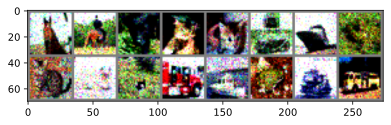

In [32]:
imshow(get_loader('speckle_noise', batch_size=16))

In [26]:
qs = np.arange(10, -1, -1) / 10
target = 'NLL'
model = ensemble['models'][0]
for type_ in tqdm(['BS'], desc='Type'):

    if type_=='DE':
        experiment = BI_thresh_DE(model, ensemble['models'], [val_loader], qs=qs, device='cuda:0')
    elif type_=='BS':
        experiment = BI_thresh_DE(model, ensemble['BS_models'], [val_loader], qs=qs, device='cuda:0')
    elif type_=='TTA':
        experiment = BI_thresh_acc_TTA(model, [val_loader], qs=qs, n_ens=20, device='cuda:0', img_size=32)
    elif type_=='Conf':
        experiment = Conf_thresh(model, [val_loader], qs=qs, device='cuda:0')
    elif type_=='MCD':
        experiment = BI_thresh_acc_MCD(model, [val_loader], qs=qs, n_ens=100, device='cuda:0')

    for severity in tqdm(range(1, 6), leave=False, desc='severity'):
        results = []
        for corr in tqdm(corruptions, leave=False, desc='Corruptions'):
            if corr == 'None':
                results_ = experiment.run([test_loader])
            else:
                ood_loader = get_loader(corr, severity=severity)
                results_ = experiment.run([ood_loader])
            results_['Corruption'] = corr
            results_.to_pickle('results/{}/{}/{}_sev{}_corr{}.pkl'.format(ds_name, target, type_, severity, corr))
            results.append(results_)

        results = pd.concat(results)
        results = results.reset_index(drop=True)
        results.to_pickle('results/{}/{}/{}_sev{}_all.pkl'.format(ds_name, target, type_, severity))

Type:   0%|          | 0/1 [00:00<?, ?it/s]

Val set:   0%|          | 0/40 [00:00<?, ?it/s]

severity:   0%|          | 0/5 [00:00<?, ?it/s]

Corruptions:   0%|          | 0/20 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Corruptions:   0%|          | 0/20 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Corruptions:   0%|          | 0/20 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Corruptions:   0%|          | 0/20 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Corruptions:   0%|          | 0/20 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

Test set:   0%|          | 0/79 [00:00<?, ?it/s]

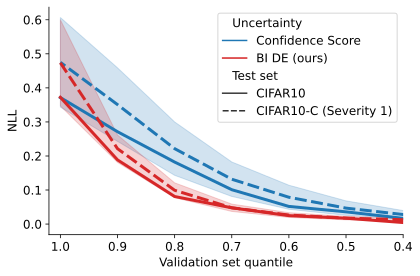

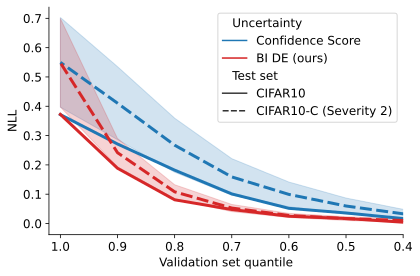

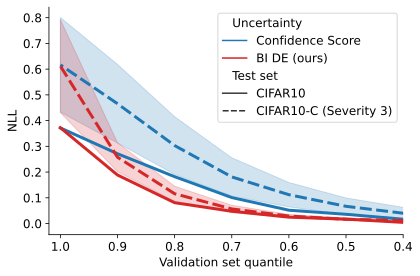

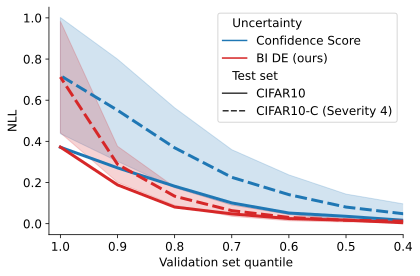

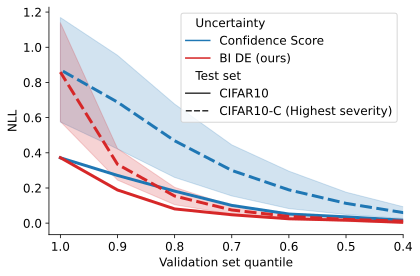

In [34]:
# Figure 11b
sns.set_palette([ '#1f77b4', '#d62728',])
target = 'NLL'
unc_type = 'DE'
hue = 'Uncertainty'

for severity in range(1, 6):
    results_DE = read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)
    #results_BS = read_results(unc_type='BS', ds_name=ds_name, severity=severity, target=target)
    results_Conf = read_results(unc_type='Conf', ds_name=ds_name, severity=severity, target=target)
    #results_combined = pd.concat([results_Conf, results_DE, results_BS])
    results_combined = pd.concat([results_Conf, results_DE])
    results_combined['Test set'] = results_combined['Corruption Severity'].replace({
        '0': 'CIFAR10',
        '1': 'CIFAR10-C (Severity 1)',
        '2': 'CIFAR10-C (Severity 2)',
        '3': 'CIFAR10-C (Severity 3)',
        '4': 'CIFAR10-C (Severity 4)',
        '5': 'CIFAR10-C (Highest severity)',
    })

    plt.rcParams.update({'font.size': 12, 'figure.dpi': 1000})
    figure = plt.figure(figsize=(6, 4))
    ax = plt.subplot(1, 1, 1)
    plot = sns.lineplot(
        data=results_combined, x='Validation set quantile', y=target, hue=hue, style='Test set', ax=ax, linewidth=3, 
        estimator=weighted_mean, errorbar=weighted_sd)
    plot.invert_xaxis()
    sns.despine()
    plt.xlim(1.02, 0.4)
    plt.tight_layout()
    plt.savefig('plots/resnet_{}_quantile_hue{}_sev{}_unc{}_{}.png'.format(ds_name, hue, severity, unc_type, target), bbox_inches='tight')
    plt.show();

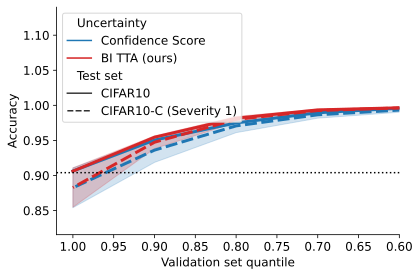

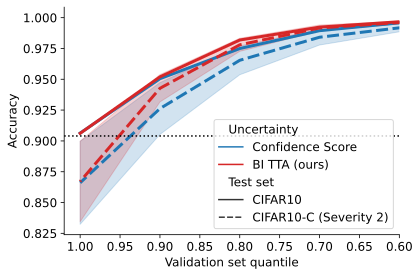

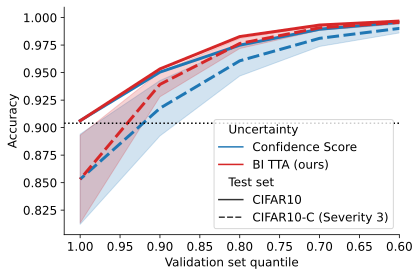

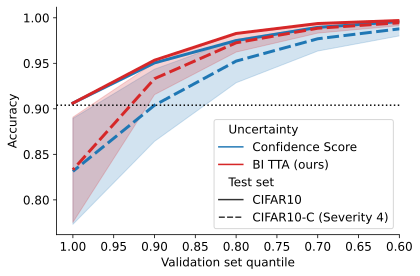

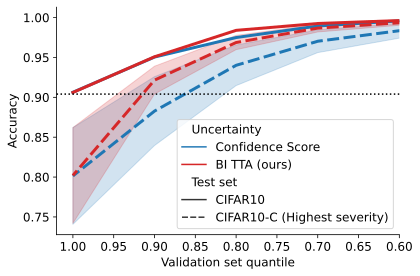

In [33]:
# Figure 1 & 12c
unc_type = 'DE'
# Figure 12d
#unc_type = 'TTA'

sns.set_palette([ '#1f77b4', '#d62728',])
target = 'Accuracy'
#unc_type = 'TTA'
hue = 'Uncertainty'

for severity in range(1, 6):
    results_DE = read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)
    #results_BS = read_results(unc_type='BS', ds_name=ds_name, severity=severity, target=target)
    results_Conf = read_results(unc_type='Conf', ds_name=ds_name, severity=severity, target=target)
    #results_combined = pd.concat([results_Conf, results_DE, results_BS])
    results_combined = pd.concat([results_Conf, results_DE])
    results_combined['Test set'] = results_combined['Corruption Severity'].replace({
        '0': 'CIFAR10',
        '1': 'CIFAR10-C (Severity 1)',
        '2': 'CIFAR10-C (Severity 2)',
        '3': 'CIFAR10-C (Severity 3)',
        '4': 'CIFAR10-C (Severity 4)',
        '5': 'CIFAR10-C (Highest severity)',
    })

    plt.rcParams.update({'font.size': 12, 'figure.dpi': 1000})
    figure = plt.figure(figsize=(6, 4))
    ax = plt.subplot(1, 1, 1)
    plot = sns.lineplot(
        data=results_combined, x='Validation set quantile', y=target, hue=hue, style='Test set', ax=ax, linewidth=3, 
        estimator=weighted_mean, errorbar=weighted_sd)
    plot.invert_xaxis()
    plot.axhline(0.904, c='black', ls='dotted')
    sns.despine()
    plt.xlim(1.02, 0.6)
    plt.tight_layout()
    plt.savefig('plots/resnet_{}_quantile_hue{}_sev{}_unc{}_{}.png'.format(ds_name, hue, severity, unc_type, target), bbox_inches='tight')
    plt.show();

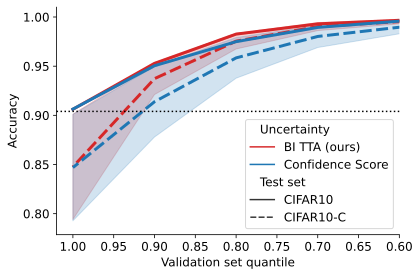

In [41]:
# Figure 12a
unc_type = 'DE'
# Figure 12b
#unc_type = 'TTA'
sns.set_palette(['#d62728', '#1f77b4'])
target = 'Accuracy'
style = 'Test set'
hue = 'Uncertainty'

results_combined = []
for severity in range(1, 6):
    results_ = read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)
    results_['Test set'] = results_['Corruption Severity'].replace({'0': 'CIFAR10', '1': 'CIFAR10-C', '2': 'CIFAR10-C', '3': 'CIFAR10-C', '4': 'CIFAR10-C', '5': 'CIFAR10-C'})
    results_combined += [results_]
    results_ = read_results(unc_type='Conf', ds_name=ds_name, severity=severity, target=target)
    results_['Test set'] = results_['Corruption Severity'].replace({'0': 'CIFAR10', '1': 'CIFAR10-C', '2': 'CIFAR10-C', '3': 'CIFAR10-C', '4': 'CIFAR10-C', '5': 'CIFAR10-C'})
    results_combined += [results_]

results_combined = pd.concat(results_combined)

plt.rcParams.update({'font.size': 12, 'figure.dpi': 1000})
figure = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
plot = sns.lineplot(
    data=results_combined, x='Validation set quantile', y=target, hue=hue, style=style, ax=ax, linewidth=3, 
    estimator=weighted_mean, errorbar=weighted_sd)
plot.invert_xaxis()
plot.axhline(0.904, c='black', ls='dotted')
sns.despine()
plt.xlim(1.02, 0.6)
plt.ylim(None, 1.01)
plt.tight_layout()
plt.savefig('plots/resnet_{}_quantile_hue{}_sev{}_unc{}_{}.png'.format(ds_name, hue, 'ALL', unc_type, target), bbox_inches='tight')
plt.show();

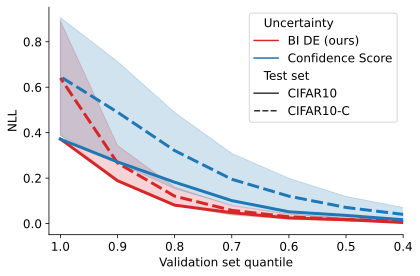

In [42]:
# Figure 11a
sns.set_palette(['#d62728', '#1f77b4'])
target = 'NLL'
unc_type = 'DE'
style = 'Test set'
hue = 'Uncertainty'

results_combined = []
for severity in range(1, 6):
    results_ = read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)
    results_['Test set'] = results_['Corruption Severity'].replace({'0': 'CIFAR10', '1': 'CIFAR10-C', '2': 'CIFAR10-C', '3': 'CIFAR10-C', '4': 'CIFAR10-C', '5': 'CIFAR10-C'})
    results_combined += [results_]
    results_ = read_results(unc_type='Conf', ds_name=ds_name, severity=severity, target=target)
    results_['Test set'] = results_['Corruption Severity'].replace({'0': 'CIFAR10', '1': 'CIFAR10-C', '2': 'CIFAR10-C', '3': 'CIFAR10-C', '4': 'CIFAR10-C', '5': 'CIFAR10-C'})
    results_combined += [results_]

results_combined = pd.concat(results_combined)

plt.rcParams.update({'font.size': 12, 'figure.dpi': 1000})
figure = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
plot = sns.lineplot(
    data=results_combined, x='Validation set quantile', y=target, hue=hue, style=style, ax=ax, linewidth=3, 
    estimator=weighted_mean, errorbar=weighted_sd)
plot.invert_xaxis()
sns.despine()
plt.xlim(1.02, 0.4)
plt.tight_layout()
plt.savefig('plots/resnet_{}_quantile_hue{}_sev{}_unc{}_{}.png'.format(ds_name, hue, 'ALL', unc_type, target), bbox_inches='tight')
plt.show();

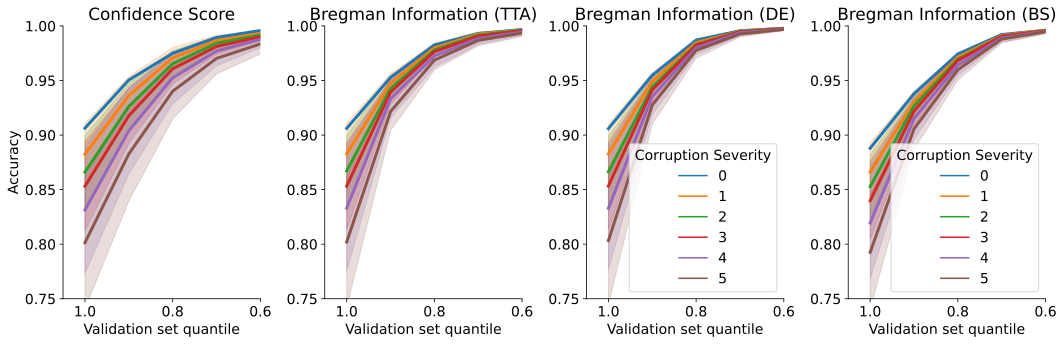

In [36]:
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
target = 'Accuracy'
hue = 'Corruption Severity'

unc_type = 'Conf'
results_Conf_all = []
for severity in range(1, 6):
    results_Conf_all += [read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)]
results_Conf_all = pd.concat(results_Conf_all)

unc_type = 'DE'
results_DE_all = []
for severity in range(1, 6):
    results_DE_all += [read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)]
results_DE_all = pd.concat(results_DE_all)

unc_type = 'BS'
results_BS_all = []
for severity in range(1, 6):
    results_BS_all += [read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)]
results_BS_all = pd.concat(results_BS_all)

unc_type = 'TTA'
results_TTA_all = []
for severity in range(1, 6):
    results_TTA_all += [read_results(unc_type=unc_type, ds_name=ds_name, severity=severity, target=target)]
results_TTA_all = pd.concat(results_TTA_all)

plt.rcParams.update({'font.size': 14, 'figure.dpi': 1000})
figure, axs = plt.subplots(1, 4, figsize=(15, 5))

ax = axs[0]
plot = sns.lineplot(
    data=results_Conf_all, x='Validation set quantile', y='Accuracy', hue=hue, ax=ax, linewidth=3,
    estimator=weighted_mean, errorbar=weighted_sd, legend=False)
#plot.axhline(1., c='black', ls='dashed')
plot.invert_xaxis()
ax.set_ylim(0.75, 1.0)
ax.set_xlim(None, 0.6)
ax.set_title('Confidence Score')
sns.despine()

ax = axs[1]
plot = sns.lineplot(
    data=results_TTA_all, x='Validation set quantile', y='Accuracy', hue=hue, ax=ax, linewidth=3, 
    estimator=weighted_mean, errorbar=weighted_sd, legend=False)
plot.invert_xaxis()
#plot.axhline(1., c='black', ls='dashed')
ax.set_ylim(0.75, 1.0)
ax.set_xlim(None, 0.6)
ax.set_ylabel('')
ax.set_title('Bregman Information (TTA)')
sns.despine()

ax = axs[2]
plot = sns.lineplot(
    data=results_DE_all, x='Validation set quantile', y='Accuracy', hue=hue, ax=ax, linewidth=3, 
    estimator=weighted_mean, errorbar=weighted_sd)
plot.invert_xaxis()
#plot.axhline(1., c='black', ls='dashed')
ax.set_ylim(0.75, 1.0)
ax.set_xlim(None, 0.6)
ax.set_ylabel('')
ax.set_title('Bregman Information (DE)')
sns.despine()

ax = axs[3]
plot = sns.lineplot(
    data=results_BS_all, x='Validation set quantile', y='Accuracy', hue=hue, ax=ax, linewidth=3, 
    estimator=weighted_mean, errorbar=weighted_sd)
plot.invert_xaxis()
#plot.axhline(1., c='black', ls='dashed')
ax.set_ylim(0.75, 1.0)
ax.set_xlim(None, 0.6)
ax.set_ylabel('')
ax.set_title('Bregman Information (BS)')
sns.despine()

plt.tight_layout()
plt.savefig('plots/resnet_cif10-C_all.png', bbox_inches='tight')
plt.show();